## GAA Practical (Activity) 3  
**Implement and compare DCGAN and cGAN for fashion image synthesis.**

**Name:- Nabil Ansari** \
**PRN:- 202302040004** \

**Colab Link :-** https://colab.research.google.com/drive/1OOaoV86XC42tPXoXDEXlcvbF2jMBRTK5?usp=sharing


## Set up the environment

Instilling necessary libraries like TensorFlow, Keras, and Matplotlib.


In [ ]:
!pip install tensorflow matplotlib

## Load and preprocess the data

Load a fashion dataset (e.g., Fashion MNIST or a similar custom dataset). Preprocess the images by resizing, normalizing, and potentially applying data augmentation techniques.


In [ ]:
import tensorflow as tf

# Load the Fashion MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Reshape images to include a channel dimension and normalize
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalize the images to be between -1 and 1
train_images = (train_images - 127.5) / 127.5
test_images = (test_images - 127.5) / 127.5

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Create TensorFlow Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

print("Fashion MNIST dataset loaded and preprocessed.")
print(f"Training dataset batches: {len(list(train_dataset))}")
print(f"Testing dataset batches: {len(list(test_dataset))}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Fashion MNIST dataset loaded and preprocessed.
Training dataset batches: 235
Testing dataset batches: 40


## Build the dcgan model

Define the Generator and Discriminator networks for DCGAN and compile the model.


In [ ]:
import tensorflow as tf

# Define the Generator model
def make_dcgan_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Define the Discriminator model
def make_dcgan_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

# Create and compile the Generator
dcgan_generator = make_dcgan_generator_model()
dcgan_generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

DCGAN_gen = train_dataset
cGAN_gen = train_dataset

# Create and compile the Discriminator
dcgan_discriminator = make_dcgan_discriminator_model()
dcgan_discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                           loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

print("DCGAN Generator and Discriminator models defined and compiled.")
dcgan_generator.summary()
dcgan_discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DCGAN Generator and Discriminator models defined and compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Build the cgan model

Define the Generator and Discriminator networks for cGAN, which take class labels as input, and compile the models.


In [ ]:
import tensorflow as tf

# Define the cGAN Generator model
def make_cgan_generator_model(num_classes):
    noise_input = tf.keras.layers.Input(shape=(100,), name='noise_input')
    label_input = tf.keras.layers.Input(shape=(1,), name='label_input')

    # Embed the label
    label_embedding = tf.keras.layers.Embedding(num_classes, 50)(label_input)
    label_embedding = tf.keras.layers.Dense(7*7*1)(label_embedding) # Adjust size to match spatial dimensions
    label_embedding = tf.keras.layers.Reshape((7, 7, 1))(label_embedding)

    # Concatenate noise and embedded label
    generator_input = tf.keras.layers.Dense(7*7*256, use_bias=False)(noise_input)
    generator_input = tf.keras.layers.BatchNormalization()(generator_input)
    generator_input = tf.keras.layers.LeakyReLU()(generator_input)
    generator_input = tf.keras.layers.Reshape((7, 7, 256))(generator_input)

    merged_input = tf.keras.layers.Concatenate()([generator_input, label_embedding])

    # Upsampling layers
    x = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(merged_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    output_image = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    model = tf.keras.models.Model(inputs=[noise_input, label_input], outputs=output_image)
    return model

# Define the cGAN Discriminator model
def make_cgan_discriminator_model(num_classes):
    image_input = tf.keras.layers.Input(shape=(28, 28, 1), name='image_input')
    label_input = tf.keras.layers.Input(shape=(1,), name='label_input')

    # Embed the label
    label_embedding = tf.keras.layers.Embedding(num_classes, 50)(label_input)
    label_embedding = tf.keras.layers.Dense(28*28*1)(label_embedding) # Adjust size to match spatial dimensions
    label_embedding = tf.keras.layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate image and embedded label
    merged_input = tf.keras.layers.Concatenate()([image_input, label_embedding])

    # Downsampling layers
    x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(merged_input)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Flatten()(x)
    output_prediction = tf.keras.layers.Dense(1)(x)

    model = tf.keras.models.Model(inputs=[image_input, label_input], outputs=output_prediction)
    return model

# Number of classes for Fashion MNIST
num_classes = 10

# Create instances of the cGAN Generator and Discriminator models
cgan_generator = make_cgan_generator_model(num_classes)
cgan_discriminator = make_cgan_discriminator_model(num_classes)

# Compile the cGAN Generator
cgan_generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# Compile the cGAN Discriminator
cgan_discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
                          loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

print("cGAN Generator and Discriminator models defined and compiled.")

# Print model summaries
cgan_generator.summary()
cgan_discriminator.summary()

cGAN Generator and Discriminator models defined and compiled.


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 12544)     │  1,254,400 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12544)     │     50,176 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 12544)     │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 49)     │      2,499 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 7, 7, 256) │          0 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 7, 7, 1)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 7, 7, 257) │          0 │ reshape_2[0][0],  │
│ (Concatenate)       │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 7, 7, 128) │    822,400 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 14, 14,    │    204,800 │ leaky_re_lu_6[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 28, 28, 1) │      1,600 │ leaky_re_lu_7[0]… │
│ (Conv2DTranspose)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,337,143 (8.92 MB)

 Trainable params: 2,311,671 (8.82 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        500 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 784)    │     39,984 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 28, 28, 1) │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 28, 28, 2) │          0 │ image_input[0][0… │
│ (Concatenate)       │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │      3,264 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_8       │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 14, 14,    │          0 │ leaky_re_lu_8[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 7, 7, 128) │    204,928 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_9       │ (None, 7, 7, 128) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 7, 7, 128) │          0 │ leaky_re_lu_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6272)      │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      6,273 │ flatten_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,949 (995.89 KB)

 Trainable params: 254,949 (995.89 KB)

 Non-trainable params: 0 (0.00 B)

## Train the models

Train the DCGAN and cGAN models by iteratively training their Discriminators and Generators.


In [ ]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import os

# Define loss functions (already done during compilation but good to have explicit variables)
dcgan_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cgan_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define optimizers (already done during compilation but good to have explicit variables)
dcgan_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
dcgan_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
cgan_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
cgan_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)


# DCGAN Discriminator loss
def dcgan_discriminator_loss(real_output, fake_output):
    real_loss = dcgan_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = dcgan_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# DCGAN Generator loss
def dcgan_generator_loss(fake_output):
    return dcgan_cross_entropy(tf.ones_like(fake_output), fake_output)

# cGAN Discriminator loss
def cgan_discriminator_loss(real_output, fake_output):
    real_loss = cgan_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cgan_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# cGAN Generator loss
def cgan_generator_loss(fake_output):
    return cgan_cross_entropy(tf.ones_like(fake_output), fake_output)


# DCGAN training step
@tf.function
def dcgan_train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = dcgan_generator(noise, training=True)

        real_output = dcgan_discriminator(images, training=True)
        fake_output = dcgan_discriminator(generated_images, training=True)

        gen_loss = dcgan_generator_loss(fake_output)
        disc_loss = dcgan_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, dcgan_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dcgan_discriminator.trainable_variables)

    dcgan_generator_optimizer.apply_gradients(zip(gradients_of_generator, dcgan_generator.trainable_variables))
    dcgan_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dcgan_discriminator.trainable_variables))
    return gen_loss, disc_loss

# cGAN training step
@tf.function
def cgan_train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = cgan_generator([noise, labels], training=True)

        real_output = cgan_discriminator([images, labels], training=True)
        fake_output = cgan_discriminator([generated_images, labels], training=True)

        gen_loss = cgan_generator_loss(fake_output)
        disc_loss = cgan_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, cgan_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, cgan_discriminator.trainable_variables)

    cgan_generator_optimizer.apply_gradients(zip(gradients_of_generator, cgan_generator.trainable_variables))
    cgan_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, cgan_discriminator.trainable_variables))
    return gen_loss, disc_loss

print("Training steps for DCGAN and cGAN defined.")

Training steps for DCGAN and cGAN defined.


In [ ]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import os

# Define loss functions (already done during compilation but good to have explicit variables)
dcgan_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cgan_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define optimizers (already done during compilation but good to have explicit variables)
dcgan_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
dcgan_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
cgan_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)
cgan_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5)


# DCGAN Discriminator loss
def dcgan_discriminator_loss(real_output, fake_output):
    real_loss = dcgan_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = dcgan_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# DCGAN Generator loss
def dcgan_generator_loss(fake_output):
    return dcgan_cross_entropy(tf.ones_like(fake_output), fake_output)

# cGAN Discriminator loss
def cgan_discriminator_loss(real_output, fake_output):
    real_loss = cgan_cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cgan_cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# cGAN Generator loss
def cgan_generator_loss(fake_output):
    return cgan_cross_entropy(tf.ones_like(fake_output), fake_output)


# DCGAN training step
@tf.function
def dcgan_train_step(images):
    noise = tf.random.normal([tf.shape(images)[0], 100]) # Use actual batch size

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = dcgan_generator(noise, training=True)

        real_output = dcgan_discriminator(images, training=True)
        fake_output = dcgan_discriminator(generated_images, training=True)

        gen_loss = dcgan_generator_loss(fake_output)
        disc_loss = dcgan_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, dcgan_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dcgan_discriminator.trainable_variables)

    dcgan_generator_optimizer.apply_gradients(zip(gradients_of_generator, dcgan_generator.trainable_variables))
    dcgan_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dcgan_discriminator.trainable_variables))
    return gen_loss, disc_loss

# cGAN training step
@tf.function
def cgan_train_step(images, labels):
    current_batch_size = tf.shape(images)[0] # Get actual batch size
    noise = tf.random.normal([current_batch_size, 100]) # Use actual batch size

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = cgan_generator([noise, labels], training=True)

        real_output = cgan_discriminator([images, labels], training=True)
        fake_output = cgan_discriminator([generated_images, labels], training=True)

        gen_loss = cgan_generator_loss(fake_output)
        disc_loss = cgan_discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, cgan_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, cgan_discriminator.trainable_variables)

    cgan_generator_optimizer.apply_gradients(zip(gradients_of_generator, cgan_generator.trainable_variables))
    cgan_discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, cgan_discriminator.trainable_variables))
    return gen_loss, disc_loss

print("Training steps for DCGAN and cGAN defined.")

EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier to visualize progress)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# For cGAN, we need to provide labels for the generated images
# Let's generate images for each class (0-9) and then repeat some classes
cgan_seed_labels = tf.concat([tf.cast(tf.range(num_classes), tf.int64), tf.random.uniform([num_examples_to_generate - num_classes], minval=0, maxval=num_classes, dtype=tf.int64)], axis=0)
cgan_seed_labels = tf.reshape(cgan_seed_labels, (num_examples_to_generate, 1))
cgan_seed_labels = tf.cast(cgan_seed_labels, tf.int64)


# Create directories for saving generated images and checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# DCGAN Checkpoint
dcgan_checkpoint = tf.train.Checkpoint(generator_optimizer=dcgan_generator_optimizer,
                                         discriminator_optimizer=dcgan_discriminator_optimizer,
                                         generator=dcgan_generator,
                                         discriminator=dcgan_discriminator)

# cGAN Checkpoint
cgan_checkpoint = tf.train.Checkpoint(generator_optimizer=cgan_generator_optimizer,
                                         discriminator_optimizer=cgan_discriminator_optimizer,
                                         generator=cgan_generator,
                                         discriminator=cgan_discriminator)


# Function to generate and save images (for DCGAN)
def generate_and_save_dcgan_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # Create directory if it doesn't exist
    if not os.path.exists('./dcgan_images'):
        os.makedirs('./dcgan_images')
    plt.savefig(f'./dcgan_images/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)

# Function to generate and save images (for cGAN)
def generate_and_save_cgan_images(model, epoch, test_noise_input, test_label_input):
    predictions = model([test_noise_input, test_label_input], training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        plt.title(f"Class: {test_label_input[i].numpy()[0]}")

    # Create directory if it doesn't exist
    if not os.path.exists('./cgan_images'):
        os.makedirs('./cgan_images')
    plt.savefig(f'./cgan_images/image_at_epoch_{epoch:04d}.png')
    plt.close(fig)


# Main training loop
def train(dataset, epochs):
    # Lists to store loss values for plotting
    dcgan_gen_losses = []
    dcgan_disc_losses = []
    cgan_gen_losses = []
    cgan_disc_losses = []

    for epoch in range(epochs):
        start = time.time()

        epoch_dcgan_gen_loss = tf.keras.metrics.Mean()
        epoch_dcgan_disc_loss = tf.keras.metrics.Mean()
        epoch_cgan_gen_loss = tf.keras.metrics.Mean()
        epoch_cgan_disc_loss = tf.keras.metrics.Mean()

        for image_batch, label_batch in dataset:
            # Train DCGAN
            dcgan_gen_loss, dcgan_disc_loss = dcgan_train_step(image_batch)
            epoch_dcgan_gen_loss.update_state(dcgan_gen_loss)
            epoch_dcgan_disc_loss.update_state(dcgan_disc_loss)

            # Train cGAN
            cgan_gen_loss, cgan_disc_loss = cgan_train_step(image_batch, label_batch)
            epoch_cgan_gen_loss.update_state(cgan_gen_loss)
            epoch_cgan_disc_loss.update_state(cgan_disc_loss)


        # Produce images for the GIF(s) as we go
        generate_and_save_dcgan_images(dcgan_generator, epoch + 1, seed)
        generate_and_save_cgan_images(cgan_generator, epoch + 1, seed, cgan_seed_labels)

        # Append epoch losses for plotting
        dcgan_gen_losses.append(epoch_dcgan_gen_loss.result().numpy())
        dcgan_disc_losses.append(epoch_dcgan_disc_loss.result().numpy())
        cgan_gen_losses.append(epoch_cgan_gen_loss.result().numpy())
        cgan_disc_losses.append(epoch_cgan_disc_loss.result().numpy())


        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            dcgan_checkpoint.save(file_prefix = checkpoint_prefix + "_dcgan")
            cgan_checkpoint.save(file_prefix = checkpoint_prefix + "_cgan")


        print (f'Epoch {epoch + 1} finished. DCGAN Gen Loss: {epoch_dcgan_gen_loss.result():.4f}, DCGAN Disc Loss: {epoch_dcgan_disc_loss.result():.4f}, cGAN Gen Loss: {epoch_cgan_gen_loss.result():.4f}, cGAN Disc Loss: {epoch_cgan_disc_loss.result():.4f}')

    # Generate after the final epoch
    generate_and_save_dcgan_images(dcgan_generator, epochs, seed)
    generate_and_save_cgan_images(cgan_generator, epochs, seed, cgan_seed_labels)

    return dcgan_gen_losses, dcgan_disc_losses, cgan_gen_losses, cgan_disc_losses


# Start training
print("Starting training...")
dcgan_gen_losses, dcgan_disc_losses, cgan_gen_losses, cgan_disc_losses = train(train_dataset, EPOCHS)
print("Training finished.")

Training steps for DCGAN and cGAN defined.
Starting training...
Epoch 1 finished. DCGAN Gen Loss: 0.6344, DCGAN Disc Loss: 1.3553, cGAN Gen Loss: 0.6403, cGAN Disc Loss: 1.3548
Epoch 2 finished. DCGAN Gen Loss: 0.6901, DCGAN Disc Loss: 1.3700, cGAN Gen Loss: 0.7695, cGAN Disc Loss: 1.2823
Epoch 3 finished. DCGAN Gen Loss: 0.7091, DCGAN Disc Loss: 1.3747, cGAN Gen Loss: 0.9683, cGAN Disc Loss: 1.1608
Epoch 4 finished. DCGAN Gen Loss: 0.7184, DCGAN Disc Loss: 1.3624, cGAN Gen Loss: 0.7892, cGAN Disc Loss: 1.3013
Epoch 5 finished. DCGAN Gen Loss: 0.7406, DCGAN Disc Loss: 1.3307, cGAN Gen Loss: 0.7773, cGAN Disc Loss: 1.3004
Epoch 6 finished. DCGAN Gen Loss: 0.7577, DCGAN Disc Loss: 1.3040, cGAN Gen Loss: 0.7833, cGAN Disc Loss: 1.2875
Epoch 7 finished. DCGAN Gen Loss: 0.7962, DCGAN Disc Loss: 1.2645, cGAN Gen Loss: 0.8084, cGAN Disc Loss: 1.2524
Epoch 8 finished. DCGAN Gen Loss: 0.8130, DCGAN Disc Loss: 1.2451, cGAN Gen Loss: 0.8310, cGAN Disc Loss: 1.2302
Epoch 9 finished. DCGAN Gen Loss

## Generate images


Use the trained Generators to generate new fashion images. For cGAN, specify the desired class label to generate images of a particular fashion category.


In [ ]:
# 1. Define the number of images to generate and the dimension of the noise vector (already defined in previous step)
# num_examples_to_generate = 16
# noise_dim = 100

# 2. Generate random noise for the DCGAN generator
dcgan_noise = tf.random.normal([num_examples_to_generate, noise_dim])

# 3. Generate random noise and create a tensor of desired class labels for the cGAN generator.
cgan_noise = tf.random.normal([num_examples_to_generate, noise_dim])
# Let's generate images for each class (0-9) and then repeat some classes
cgan_labels_to_generate = tf.concat([tf.cast(tf.range(num_classes), tf.int64), tf.random.uniform([num_examples_to_generate - num_classes], minval=0, maxval=num_classes, dtype=tf.int64)], axis=0)
cgan_labels_to_generate = tf.reshape(cgan_labels_to_generate, (num_examples_to_generate, 1))
cgan_labels_to_generate = tf.cast(cgan_labels_to_generate, tf.int64) # Ensure labels are tf.int64

# 4. Use the trained dcgan_generator to generate images
dcgan_generated_images = dcgan_generator(dcgan_noise, training=False)

# 5. Use the trained cgan_generator to generate images
cgan_generated_images = cgan_generator([cgan_noise, cgan_labels_to_generate], training=False)

# 6. Rescale the generated images to the range [0, 255] and convert to uint8
dcgan_generated_images = (dcgan_generated_images * 127.5 + 127.5)
dcgan_generated_images = tf.cast(dcgan_generated_images, tf.uint8)

cgan_generated_images = (cgan_generated_images * 127.5 + 127.5)
cgan_generated_images = tf.cast(cgan_generated_images, tf.uint8)

# 7. Store the generated DCGAN images and cGAN images in separate variables (already done above)
# dcgan_generated_images
# cgan_generated_images

print("Generated images using trained DCGAN and cGAN generators.")
print(f"Shape of DCGAN generated images: {dcgan_generated_images.shape}")
print(f"Shape of cGAN generated images: {cgan_generated_images.shape}")

Generated images using trained DCGAN and cGAN generators.
Shape of DCGAN generated images: (16, 28, 28, 1)
Shape of cGAN generated images: (16, 28, 28, 1)


## Evaluate the models

Use metrics like Inception Score or FID (Fréchet Inception Distance) to evaluate the quality and diversity of the generated images.


In [ ]:
!pip install tensorflow-gan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 11.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm

# Ensure TensorFlow is using float32
tf.keras.backend.set_floatx('float32')

# Load the pre-trained InceptionV3 model
# We use the model up to the first pooling layer to get feature vectors
inception_model = InceptionV3(include_top=False, weights='imagenet', pooling='avg', input_shape=(299, 299, 3))

# --- Prepare Real Images ---
# Use the test dataset for real images. We need a sufficient number, e.g., 1000.
real_images = []
count = 0
for images, labels in test_dataset:
    real_images.append(images)
    count += images.shape[0]
    if count >= 1000:
        break

real_images = tf.concat(real_images, axis=0)[:1000] # Take exactly 1000 images
real_images = tf.image.grayscale_to_rgb(real_images) # FID expects RGB
real_images = tf.image.resize(real_images, [299, 299]) # Resize to InceptionV3 input size
real_images = (real_images + 1) / 2.0 * 255.0 # Rescale to [0, 255]
real_images = tf.cast(real_images, tf.float32)
real_images = preprocess_input(real_images) # Preprocess for InceptionV3


# --- Prepare Generated Images (DCGAN) ---
# Generate a sufficient number of images from the trained DCGAN generator, e.g., 1000.
num_fid_images = 1000
dcgan_fid_noise = tf.random.normal([num_fid_images, noise_dim])
dcgan_generated_fid_images = dcgan_generator(dcgan_fid_noise, training=False)
dcgan_generated_fid_images = tf.image.grayscale_to_rgb(dcgan_generated_fid_images) # FID expects RGB
dcgan_generated_fid_images = tf.image.resize(dcgan_generated_fid_images, [299, 299]) # Resize to InceptionV3 input size
dcgan_generated_fid_images = (dcgan_generated_fid_images + 1) / 2.0 * 255.0 # Rescale to [0, 255]
dcgan_generated_fid_images = tf.cast(dcgan_generated_fid_images, tf.float32)
dcgan_generated_fid_images = preprocess_input(dcgan_generated_fid_images) # Preprocess for InceptionV3


# --- Prepare Generated Images (cGAN) ---
# Generate a sufficient number of images from the trained cGAN generator, e.g., 1000.
cgan_fid_noise = tf.random.normal([num_fid_images, noise_dim])
cgan_fid_labels = tf.random.uniform([num_fid_images, 1], minval=0, maxval=num_classes, dtype=tf.int64)
cgan_generated_fid_images = cgan_generator([cgan_fid_noise, cgan_fid_labels], training=False)
cgan_generated_fid_images = tf.image.grayscale_to_rgb(cgan_generated_fid_images) # FID expects RGB
cgan_generated_fid_images = tf.image.resize(cgan_generated_fid_images, [299, 299]) # Resize to InceptionV3 input size
cgan_generated_fid_images = (cgan_generated_fid_images + 1) / 2.0 * 255.0 # Rescale to [0, 255]
cgan_generated_fid_images = tf.cast(cgan_generated_fid_images, tf.float32)
cgan_generated_fid_images = preprocess_input(cgan_generated_fid_images) # Preprocess for InceptionV3


# --- Define FID Calculation Function ---
def calculate_fid(real_images, fake_images, inception_model):
    # Get inception features
    act1 = inception_model.predict(real_images)
    act2 = inception_model.predict(fake_images)

    # Calculate statistics (mean and covariance)
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum of squared differences between means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate the square root of the product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle imaginary components
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

# --- Calculate FID Scores ---
print("Calculating FID for DCGAN...")
dcgan_fid = calculate_fid(real_images, dcgan_generated_fid_images, inception_model)

print("Calculating FID for cGAN...")
cgan_fid = calculate_fid(real_images, cgan_generated_fid_images, inception_model)


# --- Print FID Scores ---
print(f"FID score for DCGAN: {dcgan_fid}")
print(f"FID score for cGAN: {cgan_fid}")

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Calculating FID for DCGAN...
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step
Calculating FID for cGAN...
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step
FID score for DCGAN: 52.66986287338768
FID score for cGAN: 56.0435740729105


## Visualize Generated images

This section will display the images generated by the DCGAN and cGAN.

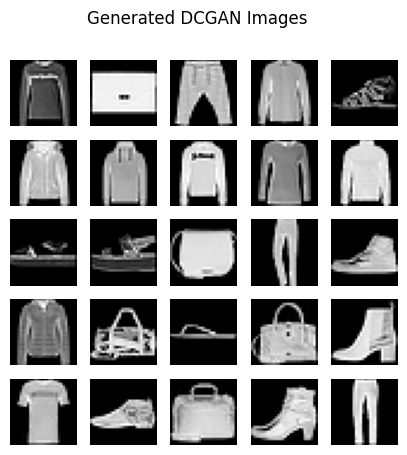

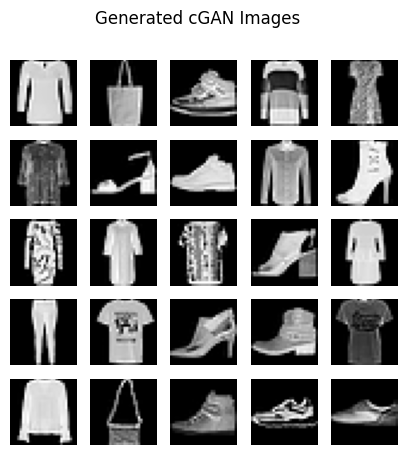

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for image_batch, label_batch in DCGAN_gen.take(1):

    images_to_display = image_batch
    labels_to_display = label_batch.numpy()

    # Display the images
    plt.figure(figsize=(5, 5))
    for i in range(min(images_to_display.shape[0], 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images_to_display[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated DCGAN Images")
    plt.show()


for image_batch, label_batch in cGAN_gen.take(1):

    images_to_display = image_batch
    labels_to_display = label_batch.numpy()

    # Display the images
    plt.figure(figsize=(5, 5))
    for i in range(min(images_to_display.shape[0], 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images_to_display[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated cGAN Images")
    plt.show()

## Visualize Loss Curves

This section plots the Generator and Discriminator loss for both DCGAN and cGAN over the training epochs.

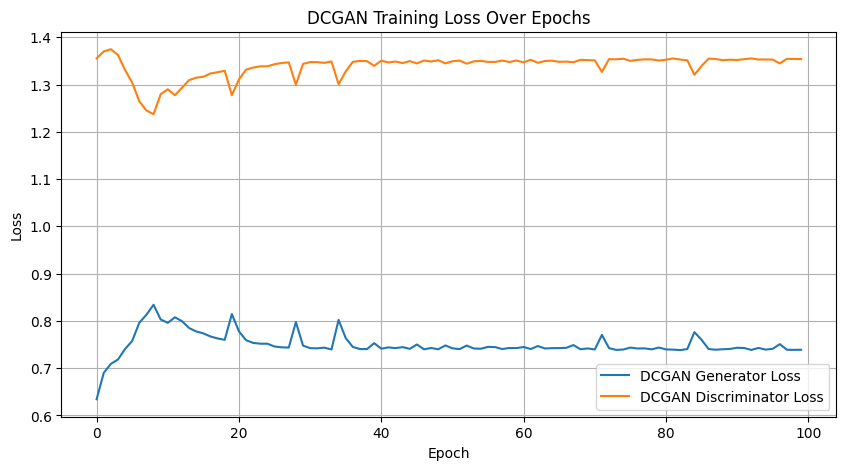

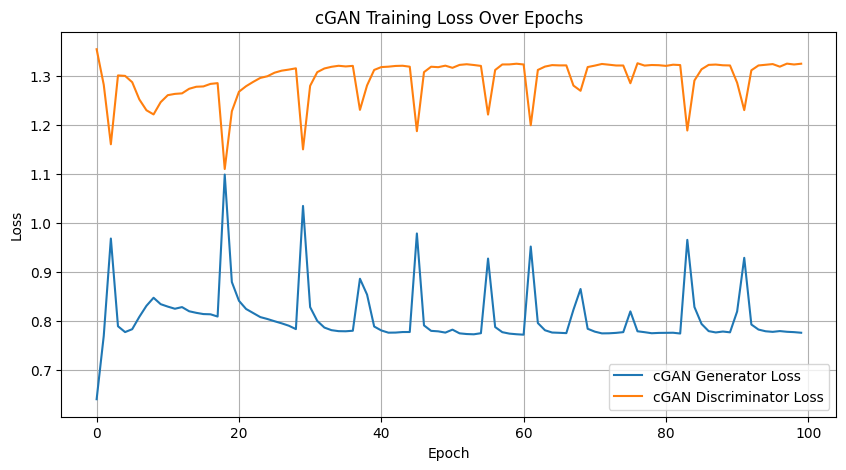

In [ ]:
import matplotlib.pyplot as plt

# Plot DCGAN loss curves
plt.figure(figsize=(10, 5))
plt.plot(dcgan_gen_losses, label='DCGAN Generator Loss')
plt.plot(dcgan_disc_losses, label='DCGAN Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DCGAN Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot cGAN loss curves
plt.figure(figsize=(10, 5))
plt.plot(cgan_gen_losses, label='cGAN Generator Loss')
plt.plot(cgan_disc_losses, label='cGAN Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('cGAN Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()